In [1]:
import numpy as np
import pyrosetta
from pyrosetta import pose_from_pdb
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import zoom
import numpy as np
import tqdm 


# Initialize PyRosetta
flags = f"""
-ignore_unrecognized_res 1
"""
pyrosetta.distributed.init(flags)

ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'P': 15,
    'S': 16
}

# R: Resolution; a: Gaussian 
def gaussian(grid_coords, atom_coord, R, a):
    """3D Gaussian centered at atom_coord."""
    # Calculate the difference between each grid coordinate and the atom coordinate.
    diff = grid_coords - atom_coord
    # Calculate k based on the provided R0 value.
    k = (np.pi / (2.4 + 0.8 * R))
    # Calculate the constant multiplier for the Gaussian function.
    c = a * (k / np.pi) ** 1.5
    
    # Calculate the squared difference for all three dimensions (x, y, z).
    squared_diff = np.sum(diff ** 2, axis=-1)
    # Compute the Gaussian value using the above results.
    predictd_density_map = c * np.exp(-k * squared_diff)
    
    return predictd_density_map

def compute_density_map(pdb, grid_size, R):
    """Computes a density map for a protein pose."""
    # Extract atomic coordinates from the pose.
    coords = [atom.xyz() for residue in pdb.residues for atom in residue.atoms()]
    # Define the 3D grid limits based on atomic coordinates, adding a buffer of 5 units.
    x_min, y_min, z_min = np.min(coords, axis=0) - 5.0
    x_max, y_max, z_max = np.max(coords, axis=0) + 5.0
    
    # Create 3D grid coordinates.
    x_range = np.arange(x_min, x_max, grid_size)
    y_range = np.arange(y_min, y_max, grid_size)
    z_range = np.arange(z_min, z_max, grid_size)
    
    grid_x, grid_y, grid_z = np.meshgrid(x_range, y_range, z_range, indexing='ij')
    grid_coords = np.stack((grid_x, grid_y, grid_z), axis=-1)
    
    # Initialize an empty density map of the same shape as our 3D grid.
    density_map = np.zeros(grid_x.shape)
    
    # Iterate over each residue and atom in the protein pose.
    for residue in pdb.residues:
        for i, atom in enumerate(residue.atoms()):
            # Extract the atomic type (e.g., 'C' for Carbon).
            atom_name = residue.atom_name(i + 1).strip()[0]  
            # Retrieve the atomic number, defaulting to 1 if the atom type isn't in our dictionary.
            a = ATOMIC_NUMBERS.get(atom_name, 1)
            # Increment the density map values using the Gaussian function for the current atom.
            density = gaussian(grid_coords, atom.xyz(), R, a)
            density_map += density
    
    return density_map

def compute_cc(map1, map2):
    
    data1 = map1
    data2 = map2
    
    # Interpolation if the maps are of different sizes
    if data1.shape != data2.shape:
        # Assuming data1 is the finer grid
        # Create interpolator for data2
        x = np.linspace(0, data2.shape[0], data2.shape[0])
        y = np.linspace(0, data2.shape[1], data2.shape[1])
        z = np.linspace(0, data2.shape[2], data2.shape[2])
        
        interpolator = RegularGridInterpolator((x, y, z), data2)
        
        # Coordinates of data1's grid
        xi = np.linspace(0, data2.shape[0], data1.shape[0])
        yi = np.linspace(0, data2.shape[1], data1.shape[1])
        zi = np.linspace(0, data2.shape[2], data1.shape[2])
        
        X, Y, Z = np.meshgrid(xi, yi, zi, indexing='ij')
        coords = np.array([X.ravel(), Y.ravel(), Z.ravel()]).T
        
        # Interpolated data
        data2_interp = interpolator(coords).reshape(data1.shape)
    else:
        data2_interp = data2

    # Compute the correlation coefficient
    mean1 = np.mean(data1)
    mean2 = np.mean(data2_interp)
    
    numerator = np.sum((data1 - mean1) * (data2_interp - mean2))
    denominator = np.sqrt(np.sum((data1 - mean1)**2) * np.sum((data2_interp - mean2)**2))
    
    cc = numerator / denominator
    return cc

# Define a resampling function to make sure both maps have the same dimensions
def resample_to_match_shape(map_to_resample, reference_map):
    scaling_factors = [
        float(ref_dim) / float(curr_dim)
        for ref_dim, curr_dim in zip(reference_map.shape, map_to_resample.shape)
    ]
    
    resampled_map = zoom(map_to_resample, scaling_factors, order=3)
    
    return resampled_map

def calculate_weight_times_density_and_average(density_maps, reference_map, weights):
    # Initialize variables to hold the total weighted CC and average density map
    average_density_map = None

    # Loop through each density map
    for i, current_density_map in enumerate(density_maps):
        # Check if resampling is needed
        if current_density_map.shape != reference_map.shape:
            current_density_map = resample_to_match_shape(current_density_map, reference_map)

        # Calculate the weighted density map for this map
        weighted_density_map = weights[i] * current_density_map

        # Add this weighted map to the average map
        if average_density_map is None:
            average_density_map = weighted_density_map
        else:
            average_density_map += weighted_density_map

    # Normalize the average density map by the sum of weights
    number_weight = len(weights)
    if number_weight > 0.0:
        average_density_map /= number_weight

    return average_density_map

In [23]:
# Define the list of PDB files
pdb_files = [
    "/mnt/d/Co-operate/He/lirui/PDB/2YDO-1/MODEL_1_cleaned_aligned.pdb",
    "/mnt/d/Co-operate/He/lirui/PDB/2YDO-1/MODEL_2_cleaned_aligned.pdb",
    "/mnt/d/Co-operate/He/lirui/PDB/2YDO-1/MODEL_3_cleaned_aligned.pdb",
    "/mnt/d/Co-operate/He/lirui/PDB/2YDO-1/MODEL_4_cleaned_aligned.pdb",
    "/mnt/d/Co-operate/He/lirui/PDB/2YDO-1/MODEL_5_cleaned_aligned.pdb",
    "/mnt/d/Co-operate/He/lirui/PDB/2YDO-1/MODEL_6_cleaned_aligned.pdb",
    "/mnt/d/Co-operate/He/lirui/PDB/2YDO-1/MODEL_7_cleaned_aligned.pdb",
    "/mnt/d/Co-operate/He/lirui/PDB/2YDO-1/MODEL_8_cleaned_aligned.pdb",
    "/mnt/d/Co-operate/He/lirui/PDB/2YDO-1/MODEL_9_cleaned_aligned.pdb",
    "/mnt/d/Co-operate/He/lirui/PDB/2YDO-1/MODEL_10_cleaned_aligned.pdb",
            ]

density_maps = [] 
for pdb in pdb_files:
    current_pdb = pose_from_pdb(pdb)
    density_map = compute_density_map(current_pdb, grid_size=1, R=1)
    density_maps.append(density_map)
    
# Reference map path
reference_pdb = "/mnt/d/Co-operate/He/lirui/PDB/2YDO-1/stratpoint_cleaned.pdb"
reference_pdb_structure = pose_from_pdb(reference_pdb)
reference_map = compute_density_map(reference_pdb_structure, grid_size=1, R=1)


core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 3 atoms at position 1 in file /mnt/d/Co-operate/He/lirui/PDB/2YDO-1/MODEL_1_cleaned_aligned.pdb. Best match rsd_type:  SER:NtermProteinFull
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 47 in file /mnt/d/Co-operate/He/lirui/PDB/2YDO-1/MODEL_1_cleaned_aligned.pdb. Best match rsd_type:  ASP
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 3 atoms at position 1 in file /mnt/d/Co-operate/He/lirui/PDB/2YDO-1/MODEL_2_cleaned_aligned.pdb. Best match rsd_type:  SER:NtermProteinFull
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 47 in file /mnt/d/Co-operate/He/lirui/PDB/2YDO-1/MODEL_2_cleaned_aligned.pdb. Best match rsd_type:  ASP
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 3 atoms at position 1 in file /mnt/d/Co-operate/He/lirui/PDB/2YDO-1/MODEL_3_cleaned_aligned.pdb. Best match rsd_type:  SER:NtermProteinFull
core.io

In [3]:
print("Type of reference_map:", type(reference_map))
if isinstance(reference_map, np.ndarray):
    print("Shape of reference_map:", reference_map.shape)
else:
    print("reference_map is not a NumPy array.")

Type of reference_map: <class 'numpy.ndarray'>
Shape of reference_map: (85, 61, 98)


In [4]:
print("Type of density_maps:", type(density_maps[0]))
if isinstance(reference_map, np.ndarray):
    print("Shape of density_maps:", density_maps[0].shape)
else:
    print("reference_map is not a NumPy array.")

Type of density_maps: <class 'numpy.ndarray'>
Shape of density_maps: (86, 63, 98)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
import logging

class DeepUNet3D(nn.Module):
    def __init__(self, num_classes):
        super(DeepUNet3D, self).__init__()
        
        # Contracting Path
        self.enc_conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool3d(2)
        self.enc_conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool3d(2)
        self.enc_conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool3d(2)
        self.enc_conv4 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool3d(2)

        # Bottleneck
        self.bottleneck_conv = nn.Conv3d(128, 256, kernel_size=3, padding=1)

        # Expanding Path
        self.up_conv4 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2, padding=0, output_padding=1)
        self.dec_conv4 = nn.Conv3d(256, 128, kernel_size=3, padding=1)
        self.up_conv3 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2, padding=0, output_padding=1)
        self.dec_conv3 = nn.Conv3d(128, 64, kernel_size=3, padding=1)
        self.up_conv2 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2, padding=0, output_padding=1)
        self.dec_conv2 = nn.Conv3d(64, 32, kernel_size=3, padding=1)
        self.up_conv1 = nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2, padding=0, output_padding=1)
        self.dec_conv1 = nn.Conv3d(32, 16, kernel_size=3, padding=1)

        # Final Pooling and Classification
        self.global_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        # Contracting Path
        c1 = self.pool1(F.relu(self.enc_conv1(x)))
        c2 = self.pool2(F.relu(self.enc_conv2(c1)))
        c3 = self.pool3(F.relu(self.enc_conv3(c2)))
        c4 = self.pool4(F.relu(self.enc_conv4(c3)))

        # Bottleneck
        bn = F.relu(self.bottleneck_conv(c4))

        # Expanding Path
        u4 = self.up_conv4(bn)
        if u4.size() != c4.size():
            u4 = F.interpolate(u4, size=c4.shape[2:])
        x = F.relu(self.dec_conv4(torch.cat([u4, c4], dim=1)))

        u3 = self.up_conv3(x)
        if u3.size() != c3.size():
            u3 = F.interpolate(u3, size=c3.shape[2:])
        x = F.relu(self.dec_conv3(torch.cat([u3, c3], dim=1)))

        u2 = self.up_conv2(x)
        if u2.size() != c2.size():
            u2 = F.interpolate(u2, size=c2.shape[2:])
        x = F.relu(self.dec_conv2(torch.cat([u2, c2], dim=1)))

        u1 = self.up_conv1(x)
        if u1.size() != c1.size():
            u1 = F.interpolate(u1, size=c1.shape[2:])
        x = F.relu(self.dec_conv1(torch.cat([u1, c1], dim=1)))

        # Final Pooling and Classification
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resize_map(map_data, target_shape=(100, 100, 100)):
    if isinstance(map_data, np.ndarray):
        map_tensor = torch.tensor(map_data, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    else:
        raise TypeError("Input must be a numpy.ndarray.")
    resized_map = F.interpolate(map_tensor, size=target_shape, mode='trilinear', align_corners=False)
    return resized_map.squeeze()

# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.epochs_no_improve = 0

def cc_loss(weights, reference, maps):
    device = reference.device
    num_distributions = weights.shape[0]  # Assuming weights are shaped [num_distributions, num_maps]
    
    # This will store the combined result of all distributions
    combined_global = torch.zeros(reference.shape, device=device)
    
    # Process each distribution's weights
    for dist_idx in range(num_distributions):
        combined = torch.zeros(reference.shape, device=device)
        for map_idx, weight in enumerate(weights[dist_idx]):
            weighted_map = weight * maps[map_idx]
            combined += weighted_map
        
        # Optionally normalize each combined map before adding to global combination
        combined /= weights[dist_idx].sum()
        
        # Add this distribution's combined map to the global combination
        combined_global += combined
    
    # Normalize the global combined map
    combined_global /= num_distributions
    
    # Flatten for correlation calculation
    combined_flat = combined_global.flatten()
    reference_flat = reference.flatten()
    
    # Calculate correlation coefficient
    mean_combined = combined_flat.mean()
    mean_reference = reference_flat.mean()
    cov = ((combined_flat - mean_combined) * (reference_flat - mean_reference)).mean()
    var_combined = ((combined_flat - mean_combined) ** 2).mean()
    var_reference = ((reference_flat - mean_reference) ** 2).mean()
    cc = cov / torch.sqrt(var_combined * var_reference)

    return -cc  # Return negative because we want to maximize the correlation


In [6]:
def standardize_maps(density_maps, target_shape=(100, 100, 100)):
    """
    Resize a list of 3D density maps to a uniform shape and convert them to a PyTorch tensor.
    
    Parameters:
        density_maps (list of numpy.ndarray): List of 3D arrays representing the density maps.
        target_shape (tuple): The target size (D, H, W) as a 3D tuple.

    Returns:
        torch.Tensor: A tensor containing all the resized maps.
    """
    standardized_maps = []
    for map_data in density_maps:
        # Convert map to tensor and add batch and channel dimensions
        map_tensor = torch.tensor(map_data, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        # Resize map using trilinear interpolation
        resized_map = F.interpolate(map_tensor, size=target_shape, mode='trilinear', align_corners=False)
        # Optionally flatten the map if needed for your model input
        standardized_maps.append(resized_map.squeeze(0).flatten())  # Remove batch dimension and flatten

    # Stack all maps along a new dimension
    return torch.stack(standardized_maps)

In [7]:
# Assuming density_maps and reference_map are defined
density_maps_tensor = torch.stack([resize_map(m) for m in density_maps]).unsqueeze(1)
reference_map_resized = resize_map(reference_map).unsqueeze(0).repeat(len(density_maps), 1, 1, 1, 1)

train_dataset = TensorDataset(density_maps_tensor, reference_map_resized)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
valid_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepUNet3D(len(density_maps)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.01)
early_stopping = EarlyStopping(patience=20, verbose=True)

# Training with validation and early stopping
min_val_loss = float('inf')
for epoch in range(300):
    model.train()
    train_loss = 0
    for maps, reference in train_loader:
        maps, reference = maps.to(device), reference.to(device)
        optimizer.zero_grad()
        weights = model(maps)
        loss = cc_loss(weights, reference, maps)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    scheduler.step()
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for maps, ref in valid_loader:
            maps, ref = maps.to(device), ref.to(device)
            val_loss += cc_loss(model(maps), ref, maps).item()

    val_loss /= len(valid_loader)
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), '/mnt/d/Co-operate/He/lirui/Net/model_best.pth')

    logging.info(f'Epoch {epoch}: Train Loss {train_loss/len(train_loader):.4f}, Val Loss {val_loss:.4f}')
    print(f'Epoch {epoch}: Train Loss {train_loss/len(train_loader):.4f}, Val Loss {val_loss:.4f}')

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# Save the model weights
torch.save(model.state_dict(), '/mnt/d/Co-operate/He/lirui/Net/model_3dcnnmdn_weights.pth')
print("Model saved successfully.")

Epoch 0: Train Loss -0.6892, Val Loss -0.6992
Epoch 1: Train Loss -0.7067, Val Loss -0.6994
Epoch 2: Train Loss -0.4186, Val Loss -0.6998
Epoch 3: Train Loss -0.5023, Val Loss -0.7001
Epoch 4: Train Loss -0.5959, Val Loss -0.7005
Epoch 5: Train Loss -0.5759, Val Loss -0.7007
Epoch 6: Train Loss -0.5214, Val Loss -0.7010
Epoch 7: Train Loss -0.5878, Val Loss -0.7012
Epoch 8: Train Loss -0.6259, Val Loss -0.7015
Epoch 9: Train Loss -0.6448, Val Loss -0.7018
Epoch 10: Train Loss -0.5946, Val Loss -0.7020
Epoch 11: Train Loss -0.6595, Val Loss -0.7023
Epoch 12: Train Loss -0.5231, Val Loss -0.7026
Epoch 13: Train Loss -0.6474, Val Loss -0.7029
Epoch 14: Train Loss -0.6274, Val Loss -0.7031
Epoch 15: Train Loss -0.5797, Val Loss -0.7034
Epoch 16: Train Loss -0.6212, Val Loss -0.7036
Epoch 17: Train Loss -0.6690, Val Loss -0.7038
Epoch 18: Train Loss -0.6701, Val Loss -0.7041
Epoch 19: Train Loss -0.6734, Val Loss -0.7042
Epoch 20: Train Loss -0.7023, Val Loss -0.7044
Epoch 21: Train Loss -0

In [8]:
from torch.utils.data import DataLoader, TensorDataset

def resize_map(map_data, target_shape=(100, 100, 100)):
    # Convert NumPy array to a PyTorch tensor if not already a tensor
    if isinstance(map_data, np.ndarray):
        map_tensor = torch.tensor(map_data, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    else:
        raise TypeError("Input must be a numpy.ndarray.")

    # Resize the map using trilinear interpolation
    resized_map = F.interpolate(map_tensor, size=target_shape, mode='trilinear', align_corners=False)
    return resized_map.squeeze()

# Data preparation
density_maps_tensor = torch.stack([resize_map(m) for m in density_maps]).unsqueeze(1)
reference_map_resized = resize_map(reference_map).unsqueeze(0).repeat(len(density_maps), 1, 1, 1)

train_dataset = TensorDataset(density_maps_tensor, reference_map_resized)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
valid_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepUNet3D(len(density_maps)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.01)

# Load the best model
model.load_state_dict(torch.load('/mnt/d/Co-operate/He/lirui/Net/model_best.pth'))

# Set the model to evaluation mode
model.eval()

# Ensure both the model and data are on the same device (GPU if CUDA is available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Assuming validation data is prepared similar to training data
density_maps_tensor = density_maps_tensor.to(device)
reference_map_resized = reference_map_resized.to(device)

with torch.no_grad():
    # Perform the forward pass
    validation_weights = model(density_maps_tensor)
    validation_loss = cc_loss(validation_weights, reference_map_resized, density_maps_tensor)

    print(f"Validation Loss: {validation_loss.item()}")
    print(f'Weights: {validation_weights}')



Validation Loss: -0.7211878299713135
Weights: tensor([[ 0.2410,  0.1669,  0.1864,  0.1370,  0.2025,  0.0730, -0.0224, -0.1293,
         -0.1135,  0.1324],
        [ 0.2410,  0.1668,  0.1865,  0.1370,  0.2025,  0.0731, -0.0222, -0.1293,
         -0.1133,  0.1325],
        [ 0.2411,  0.1668,  0.1865,  0.1370,  0.2025,  0.0731, -0.0223, -0.1293,
         -0.1133,  0.1324],
        [ 0.2410,  0.1669,  0.1864,  0.1369,  0.2026,  0.0729, -0.0226, -0.1293,
         -0.1137,  0.1324],
        [ 0.2411,  0.1667,  0.1865,  0.1372,  0.2024,  0.0733, -0.0219, -0.1293,
         -0.1128,  0.1325],
        [ 0.2410,  0.1667,  0.1865,  0.1371,  0.2025,  0.0732, -0.0221, -0.1293,
         -0.1131,  0.1325],
        [ 0.2411,  0.1667,  0.1865,  0.1371,  0.2024,  0.0732, -0.0220, -0.1293,
         -0.1130,  0.1325],
        [ 0.2410,  0.1668,  0.1865,  0.1370,  0.2025,  0.0730, -0.0223, -0.1293,
         -0.1133,  0.1325],
        [ 0.2408,  0.1665,  0.1868,  0.1371,  0.2023,  0.0732, -0.0217, -0.1292,
 

/tmp/ipykernel_1229/3808573994.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(weights_array[:, i], ax=axes[i], fill=True, common_norm=False, palette="crest",
/tmp/ipykernel_1229/3808573994.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(weights_array[:, i], ax=axes[i], fill=True, common_norm=False, palette="crest",
/tmp/ipykernel_1229/3808573994.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(weights_array[:, i], ax=axes[i], fill=True, common_norm=False, palette="crest",
/tmp/ipykernel_1229/3808573994.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(weights_array[:, i], ax=axes[i], fill=True, common_norm=False, palette="crest",
/tmp/ipykernel_1229/3808573994.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(weights_array[:, i], ax=axes[i], fi

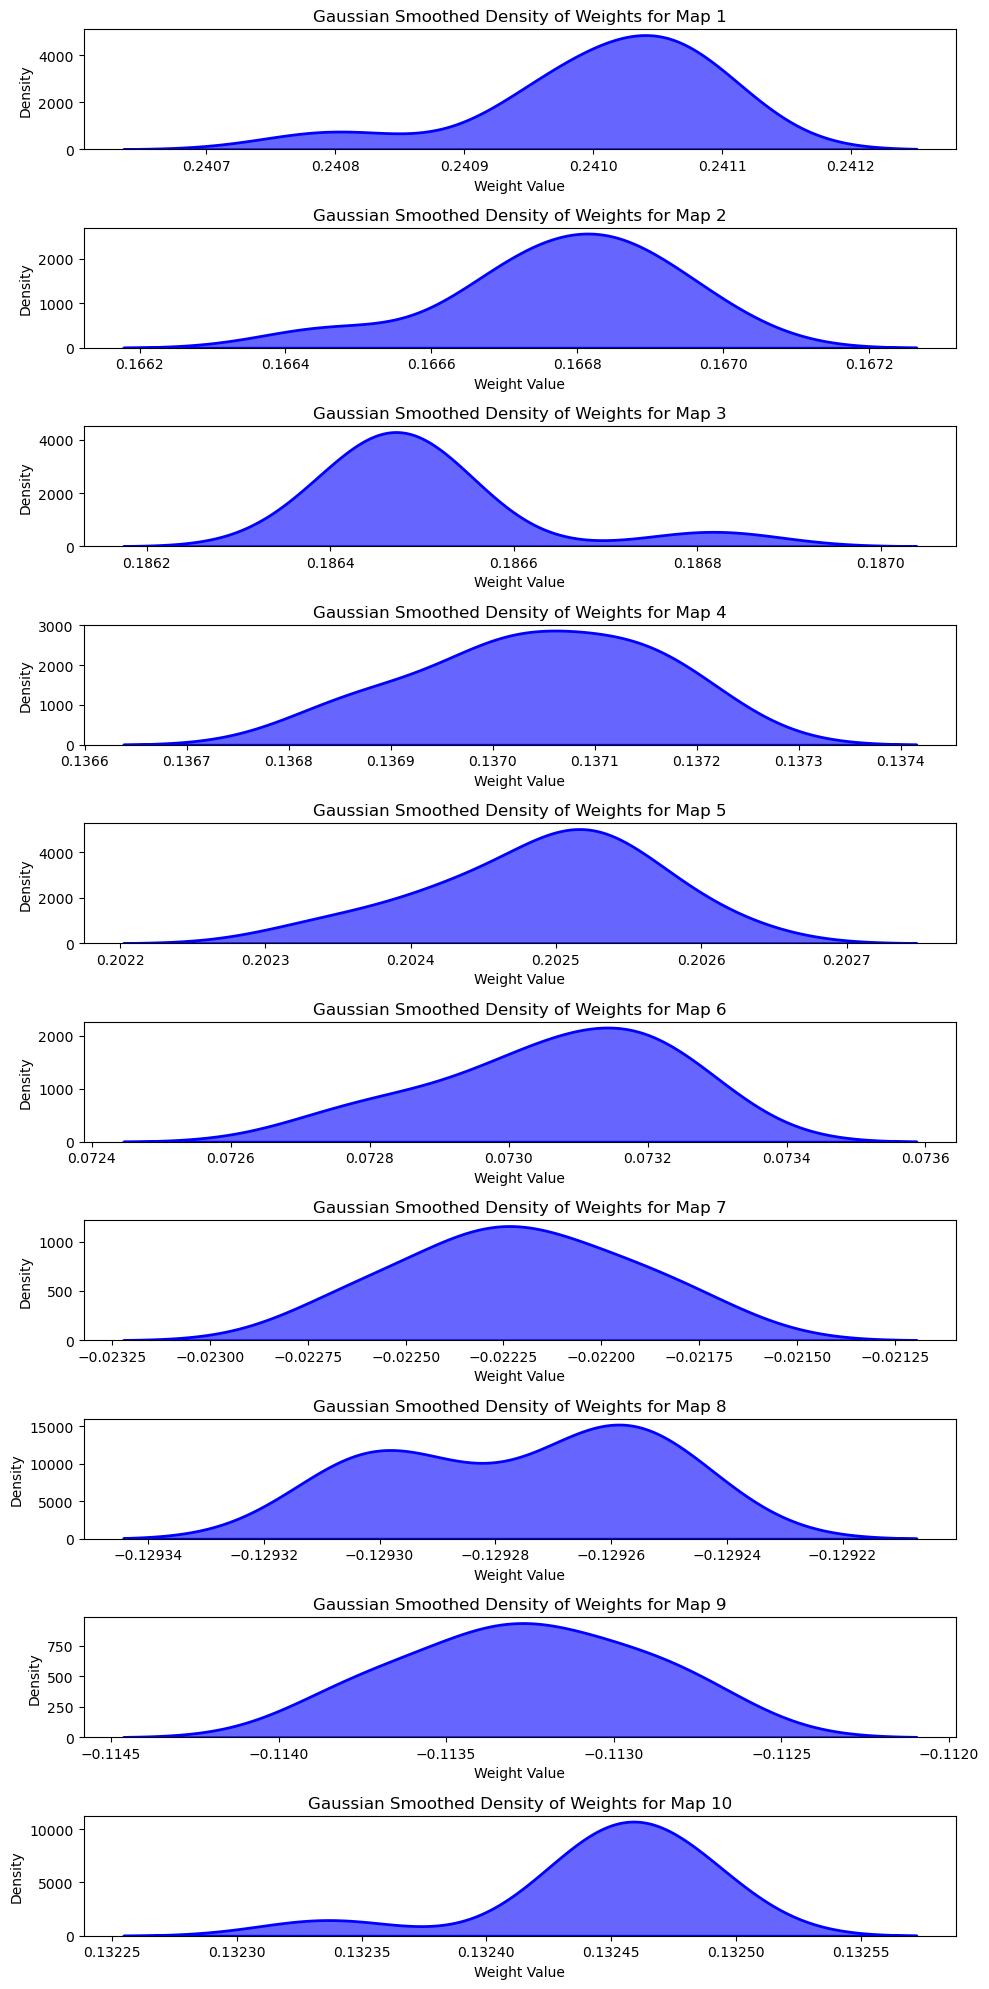

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming `validation_weights` is a tensor from PyTorch model's output
# Convert weights tensor to numpy for easier handling in matplotlib
weights_array = validation_weights.detach().cpu().numpy()

# Number of maps corresponds to the number of different weights output by the model
num_maps = weights_array.shape[1]

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=num_maps, figsize=(10, 2 * num_maps))

# Plot Gaussian smoothed density for each map's weights
for i in range(num_maps):
    sns.kdeplot(weights_array[:, i], ax=axes[i], fill=True, common_norm=False, palette="crest",
                alpha=0.6, linewidth=2, color='blue')
    axes[i].set_title(f'Gaussian Smoothed Density of Weights for Map {i+1}')
    axes[i].set_xlabel('Weight Value')
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()


density_map[0] shape before processing: (86, 63, 98), ndim: 3
density_map[1] shape before processing: (85, 64, 95), ndim: 3
density_map[2] shape before processing: (89, 61, 96), ndim: 3
density_map[3] shape before processing: (83, 68, 98), ndim: 3
density_map[4] shape before processing: (89, 56, 98), ndim: 3
density_map[5] shape before processing: (90, 58, 98), ndim: 3
density_map[6] shape before processing: (89, 58, 97), ndim: 3
density_map[7] shape before processing: (83, 65, 97), ndim: 3
density_map[8] shape before processing: (83, 66, 100), ndim: 3
density_map[9] shape before processing: (80, 67, 101), ndim: 3
Target shape: (90, 68, 101), number of dimensions: 3
density_map[0] adjusted shape: (86, 63, 98), ndim: 3
density_map[1] adjusted shape: (85, 64, 95), ndim: 3
density_map[2] adjusted shape: (89, 61, 96), ndim: 3
density_map[3] adjusted shape: (83, 68, 98), ndim: 3
density_map[4] adjusted shape: (89, 56, 98), ndim: 3
density_map[5] adjusted shape: (90, 58, 98), ndim: 3
density

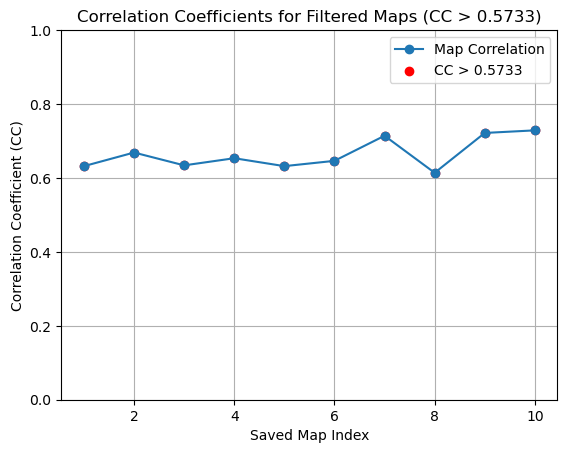

In [34]:
import subprocess
import re
import matplotlib.pyplot as plt
import numpy as np
import mrcfile
from scipy.ndimage import zoom
import os

import numpy as np
import mrcfile
from scipy.ndimage import zoom
import os
import subprocess
import re
import itertools
import matplotlib.pyplot as plt

# 假设 density_maps 已经加载并存储在列表中
# 如果尚未加载，请确保 density_maps 和 reference_map 已经正确加载

# 检查密度图的形状
for idx, density_map in enumerate(density_maps):
    print(f"density_map[{idx}] shape before processing: {density_map.shape}, ndim: {density_map.ndim}")

# 计算目标形状
target_shape = tuple(np.max([dm.shape for dm in density_maps], axis=0))
max_dims = len(target_shape)
print(f"Target shape: {target_shape}, number of dimensions: {max_dims}")

# 将所有密度图的形状扩展到相同的维度数量
for idx, density_map in enumerate(density_maps):
    original_shape = density_map.shape
    while density_map.ndim < max_dims:
        density_map = np.expand_dims(density_map, axis=-1)
    density_maps[idx] = density_map  # 更新密度图
    print(f"density_map[{idx}] adjusted shape: {density_map.shape}, ndim: {density_map.ndim}")

# 再次计算 target_shape，确保其维度数量与密度图一致
target_shape = tuple(np.max([dm.shape for dm in density_maps], axis=0))
print(f"Updated target_shape: {target_shape}")

# 调整密度图到目标形状
resized_density_maps = []
for idx, density_map in enumerate(density_maps):
    print(f"\nProcessing density_map[{idx}]")
    print(f"Adjusted shape: {density_map.shape}, ndim: {density_map.ndim}")

    # 检查是否有维度大小为 1
    if any(s == 1 for s in density_map.shape):
        print(f"density_map[{idx}] has a dimension of size 1, considering to adjust.")
        # 在该维度上重复数据，使其与 target_shape 一致
        density_map = np.broadcast_to(density_map, target_shape)
    else:
        # 计算缩放因子
        zoom_factors = [n / o for n, o in zip(target_shape, density_map.shape)]
        print(f"zoom_factors: {zoom_factors}")

        # 调整密度图大小
        density_map = zoom(density_map, zoom_factors, order=1)
    resized_density_maps.append(density_map)
    print(f"resized_density_map[{idx}] shape: {density_map.shape}")

# 处理参考密度图
print(f"Reference map shape before processing: {reference_map.shape}, ndim: {reference_map.ndim}")
while reference_map.ndim < max_dims:
    reference_map = np.expand_dims(reference_map, axis=-1)
print(f"Reference map shape after processing: {reference_map.shape}, ndim: {reference_map.ndim}")

# 保存处理后的参考密度图
reference_map_path = "/mnt/d/Co-operate/He/lirui/PDB/2YDO-1/reference_density_map_processed.mrc"
with mrcfile.new(reference_map_path, overwrite=True) as mrc:
    mrc.set_data(reference_map.astype(np.float32))
print(f"Processed reference map saved to {reference_map_path}")

# 基础路径设置
map1_base_path = '/mnt/d/Co-operate/He/lirui/PDB/2YDO-1/density_map_'
map2 = reference_map_path
output_base_path = '/mnt/d/Co-operate/He/lirui/PDB/2YDO-1/E_MAP_Sampling_'

# 计算密度图之间的平均 CC
cc_values = []
num_maps = len(resized_density_maps)
for i, j in itertools.combinations(range(num_maps), 2):
    map1 = resized_density_maps[i].flatten()
    map2 = resized_density_maps[1].flatten()
    # 计算 Pearson 相关系数
    cc = np.corrcoef(map1, map2)[0, 1]
    cc_values.append(cc)
    print(f"CC between map {i+1} and map {1}: {cc:.4f}")

# 计算平均 CC
average_cc = np.mean(cc_values)
print(f"\nAverage CC of the 10 density maps: {average_cc:.4f}")

# 初始化用于存储相关系数、有效地图计数和权重
correlations = []
saved_maps = 0
saved_weights = []

# 设置最大运行次数以防止无限循环
max_runs = 1000

# 主循环：计算相关系数并在 CC > average_cc 时保存地图
run = 0  # 运行计数
while saved_maps < 10 and run < max_runs:
    # 生成随机权重
    random_indices = np.random.randint(weights_array.shape[1], size=weights_array.shape[0])
    sub_weights = weights_array[np.arange(weights_array.shape[0]), random_indices]

    # 计算密度图的加权和
    weighted_sum = np.zeros(target_shape, dtype=np.float32)
    for weight, resized_density_map in zip(sub_weights, resized_density_maps):
        weighted_sum += weight * resized_density_map

    # 归一化
    total_weight = np.sum(sub_weights)
    if total_weight == 0:
        print(f"运行 {run+1}: 总权重为零，跳过此运行。")
        run += 1
        continue
    normalized_map = weighted_sum / total_weight

    # 保存临时 .mrc 文件用于计算相关系数
    temp_map_path = f'{output_base_path}temp_{run+1}.mrc'
    with mrcfile.new(temp_map_path, overwrite=True) as mrc:
        mrc.set_data(normalized_map.astype(np.float32))

    # 构建 ChimeraX 命令以计算相关系数
    # 使用 'volume' 命令设置阈值为 0.0
    chimerax_command = (
        f"chimerax --nogui --cmd 'open {temp_map_path}; "
        f"open {reference_map_path}; "
        f"volume #1 level 0.0; "
        f"volume #2 level 0.0; "
        f"fitmap #1 inMap #2 metric correlation; "
        f"quit'"
    )

    # 运行 ChimeraX 命令并捕获输出
    result = subprocess.run(chimerax_command, shell=True, capture_output=True, text=True)

    # 提取输出，包括标准错误
    output = result.stdout + result.stderr

    # 使用正则表达式查找相关系数值
    match = re.search(r'Correlation\s*=\s*([0-9.]+)', output, re.IGNORECASE)
    if match:
        correlation = float(match.group(1))
        print(f"运行 {run+1}, CC: {correlation:.4f}")
        if correlation > average_cc:
            # 保存满足条件的地图
            final_output_path = f'{output_base_path}{saved_maps+1}_filtered.mrc'
            with mrcfile.new(final_output_path, overwrite=True) as mrc:
                mrc.set_data(normalized_map.astype(np.float32))
            print(f"过滤后的加权平均密度图已保存为 {final_output_path}，运行 {run+1}")

            # 记录相关系数并增加计数
            correlations.append(correlation)
            saved_maps += 1

            # 保存对应的权重
            saved_weights.append(sub_weights)
            weights_output_path = f'{output_base_path}{saved_maps}_weights.txt'
            np.savetxt(weights_output_path, sub_weights, fmt='%.4f')
            print(f"权重已保存为 {weights_output_path}，运行 {run+1}")
        else:
            # 如果 CC 不高于平均 CC，删除临时文件
            os.remove(temp_map_path)
            print(f"临时文件 {temp_map_path} 已删除（CC < average_cc）")
    else:
        print(f"运行 {run+1} 计算 CC 失败")
        print(f"ChimeraX 输出:\n{output}")
        # 删除临时文件
        os.remove(temp_map_path)
        print(f"临时文件 {temp_map_path} 已删除（CC 计算失败）")

    # 增加运行计数
    run += 1

# 检查是否有保存的地图
if saved_maps == 0:
    print("未找到 CC > average_cc 的地图。")
else:
    # 绘制保存的相关系数
    plt.figure()
    plt.plot(range(1, saved_maps+1), correlations, marker='o', label="Map Correlation")
    plt.title(f'Correlation Coefficients for Filtered Maps (CC > {average_cc:.4f})')
    plt.xlabel('Saved Map Index')
    plt.ylabel('Correlation Coefficient (CC)')
    plt.ylim(0, 1)  # 设置 y 轴范围从 0 到 1
    plt.grid(True)

    # 突出显示 CC > average_cc 的点
    plt.scatter(range(1, saved_maps+1), correlations, color='red', label=f"CC > {average_cc:.4f}")
    plt.legend()

    # 保存绘图
    plot_output_path = f'{output_base_path}correlation_plot.png'
    plt.savefig(plot_output_path)
    print(f"相关系数图已保存为 {plot_output_path}")
    # 显示绘图
    plt.show()

